# Stationary OT on the *Arabidopsis* Root Tip

In this notebook, we run statOT on a 10,000 cell subset of the *Arabidopsis thaliana* root atlas from Shahan et al. [1]. The dataset contains RNA-seq data for 110,000 cells from the first 0.5cm of the root tip, capturing the root cap, meristem, elongation zone, and part of the maturation zone. Stem cells occur close to the tip of the root and then differentiate into ten distinct lineages, with cells becoming more differentiated as they increase in distance from the stem cells. While new cells are constantly produced in the meristem as the root elongates, the bottom 0.5cm is expected to be in equilibrium, exhibiting the same distribution of cells over time.

In [1]:
# Run only if using Colab
!git clone https://github.com/zsteve/statOT
!pip install statot cellrank scanpy pot colour pykeops
import os
os.chdir("statOT/examples")

fatal: destination path 'statOT' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import scipy
import scanpy
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import ipywidgets as widgets
import anndata
import statot
import colour
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data
The `data` folder in this directory includes all of the data you will need for this tutorial. Here we load a 10,000 cell subset of cells from the atlas.

For our analysis we will use:
- the expression matrix
- a pseudotime
- lineage annotations
- developmental zone annotations

In [3]:
adata = anndata.AnnData(X = scipy.sparse.load_npz('data/expr.npz'),
                        obs = pd.read_csv('data/obs.csv', index_col=0),
                        var = pd.read_csv('data/var.csv', index_col=0))

In [4]:
adata.obsm['X_umap'] = np.array([adata.obs.x, adata.obs.y]).T

Next we load average growth rates by lineage that were calculated using imaging data from Rahni and Birnbaum [2]. We assign cells in the meristem the average growth rate for their lineage and give all cells outside the meristem a growth rate of 1. A growth rate of one means that the cell is neither dividing nor dying.

In [5]:
growth_rates = pd.read_csv('data/growth-rates-by-lineage.csv', index_col=0)

def assign_growth(cell):
    if cell['time.anno'] == 'Meristem':
        return growth_rates.loc[cell['celltype.anno'], 'Mean_Daily_Growth_Rate']
    else:
        return 1
    
adata.obs['growth'] = adata.obs.apply(assign_growth, axis=1)

### Visualize Data

Here we visualize the pseudotime, growth rates, and lineages. The pseudotime and lineage annotations will be used to determine the sinks and the growth rates are important for capturing where mass is being created and removed due to cell division and death.

In [6]:
# Generate colors by lineage for visualization
lineage_colors = {"Putative Quiescent Center": "#9400d3", "Stem Cell Niche": 'tab:pink', "Columella": "#5ab953", 
                  "Lateral Root Cap": "#bfef45", "Atrichoblast": "#008080", "Trichoblast": "#21B6A8", 
                  "Cortex": "#82b6ff", "Endodermis": "#0000FF", "Pericycle": "#ff9900", 
                  "Phloem": "#e6194b", "Xylem": "#9a6324", "Procambium": "#ffe119"}

adata.obs['lineage_color'] = adata.obs['celltype.anno'].apply(lambda x: lineage_colors[x])

def create_legend_entry(lin):
    label = lin if lin != 'Putative Quiescent Center' else 'Quiescent Center'
    return Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=lineage_colors[lin], markersize=10)

lineage_handles = [create_legend_entry(lin) for lin in lineage_colors.keys()]

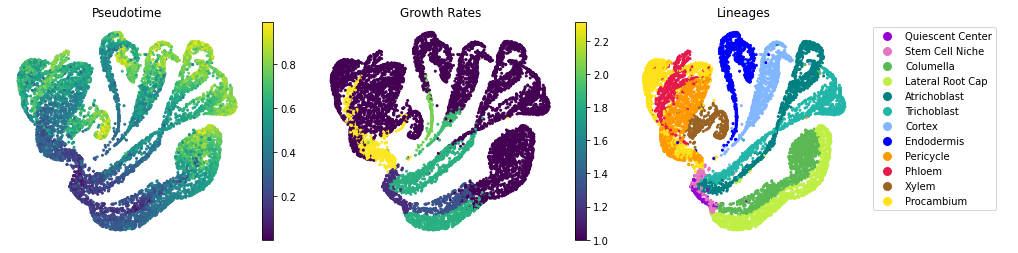

In [7]:
# Plot pseudotime, growth rates, and lineages
fig = plt.figure(figsize = (18, 4))
gs = fig.add_gridspec(1, 13)

plt.subplot(gs[:,:4])
plt.axis('off')
plt.title('Pseudotime')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s = 4, c = adata.obs['consensus.time'])
plt.colorbar()

plt.subplot(gs[:, 4:8])
plt.axis('off')
plt.title('Growth Rates')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s = 4, c = adata.obs['growth'])
plt.colorbar()

plt.subplot(gs[:,8:11])
plt.axis('off')
plt.title('Lineages')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s = 4, c = adata.obs['lineage_color'])

plt.subplot(gs[:,11:])
plt.axis('off')
plt.legend(handles=lineage_handles, loc='upper left')

plt.show()

### Assign Sources and Sinks
Based on our equilibrium assumption and the proportion of cells in the meristem, we would expect 3-6% of cells from each lineage would leave the bottom 0.5cm of root tip in a 6 hour time-step due to root growth. So, we choose to assign the 5% of most differentiated cells as sinks based on pseudotime. Varying parameters, we found our results to be robust for sink percentages from 2.5-10% and time-steps from 3-12 hours. We assign all non-sink cells as sources.

In [8]:
# Assign the 5% most differentited cells by pseudotime in each lineage as sinks
lineages = pd.unique(adata.obs['celltype.anno']) 
terminal_lineages = [lin for lin in lineages if lin not in ['Putative Quiescent Center', 'Stem Cell Niche']]
adata.obs['sink'] = False

for lin in terminal_lineages:
        sink_percentile = 0.95
        thresh = adata.obs.loc[adata.obs['celltype.anno'] == lin]['consensus.time'].quantile(sink_percentile)
        adata.obs.loc[adata.obs['celltype.anno'] == lin, 'sink'] = (adata.obs[adata.obs['celltype.anno'] == lin]['consensus.time'] >= thresh)

In [9]:
adata.obs['source'] = adata.obs['sink'].apply(lambda x: not x)

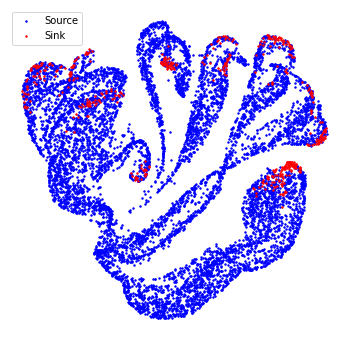

In [10]:
# Plot sources and sinks on the umap
plt.figure(figsize=(6,6))
plt.scatter(adata.obs.x[adata.obs.source], adata.obs.y[adata.obs.source], color = 'blue', s = 8, marker='.', label='Source')
plt.scatter(adata.obs.x[adata.obs.sink], adata.obs.y[adata.obs.sink], color = 'red', s = 8, marker='.', label='Sink')
plt.legend()
plt.axis('off')
plt.show()

### Generate the Coupling

Next, we generate the coupling which is a mapping between the dataset and itself captured in a N_CELL x N_CELL matrix. Element [i,j] represents the amount of mass from cell *i* we expect to transport to cell *j* after time *dt*, accounting for growth. Cells mapping to the sinks are considered to have exited the system. 

The coupling is calculated using optimal transport to minimize the distance cells travel in gene expression space subject to mass conservation. We are actively working on a manuscript which thoroughly covers the mathematical framework of the model.

For computational feasibility, we compute the coupling on the distance between cells in PCA space instead of full gene expression space.

In [11]:
scanpy.pp.pca(adata, use_highly_variable = False)

In [12]:
# Generate the cost matrix as the Euclidean distance between cells in PCA space
C = np.square(euclidean_distances(adata.obsm['X_pca'], adata.obsm['X_pca']))

To calculate the coupling you must provide the cell distance matrix, sources, sinks, sink weights, cost matrix, growth rates, time step, epsilon, and method. The cell distance matrix, sources, sinks, sink weights, and growth rates are informed by the biology of your problem. However, the other parameters can be varied to modify the coupling:
- The time step controls how much growth occurs between the versions of the dataset that are coupled.
- Epsilon controls the degree of entropic regularization, where lower values of epsilon result in sparser couplings.
- For the method you can choose entropic ('ent') or quadratic ('quad') optimal transport. Quadratic optimal transport generally provides more sparse couplings than entropic, but can be more sensitive to parameter choices, resulting in a singular matrix from which you cannot derive long-term fate probabilities for small epsilon.

**Note:** Calculating the coupling for 10,000 cells take several minutes.

In [13]:
# set up growth rates to supply
growth = adata.obs.growth.copy()
growth.loc[adata.obs.sink == True] = 0 # sinks have a growth rate of 0 (i.e. they are fully replaced)

In [14]:
gamma, mu, nu = statot.statot(adata.obsm['X_pca'], C = C, 
                              eps = 0.025*np.mean(C), method = "ent", g = growth, dt = 0.25,
                              maxiter = 5000, tol = 1e-9)

To use the output of the coupling, we first normalize the result. P is a N_CELL x N_CELL matrix where cell [i,j] represents the amount of mass expected to move from cell $i$ to cell $j$ after time $dt$.

In [15]:
P = statot.inference.row_normalise(gamma, sink_idx = adata.obs.sink)

Next, we compute the long-term fate probabilities of cells. The `compute_fate_probs_lineages` function aggregates fate probabilities by lineage so element [i,j] of B_type represents the probability of cell *i* leaving the system through a sink of type *j*. The sink_lineages vector tells you the mapping of your cell types to the columns of B_type. If you are interested in the probability of cells ending up in individual sinks, you can use the `compute_fate_probs` function.

In [16]:
B_type, sink_lineages = statot.compute_fate_probs_lineages(P, adata.obs['sink'], adata.obs['celltype.anno'])

### Visualize Transition Matrices

We can now visualize the long-term fate probabilities of cells by visualizing the the transition matrix aggregated by lineage. In these visuals, element [i,j] represents the probability of a cell with a label of type *i* ending up in a sink of type *j*. We produce a fate matrix for each zone where we expect cells further in development to be more likely to stay within their labeled fate.

In [17]:
# Create transition matrices by developmental zone
zones = ['Full', 'Meristem', 'Elongation', 'Maturation']
fate_matrices = {}

for zone in zones:
    fate_matrix = np.zeros((len(lineages), len(lineages)))
    for i in range(len(lineages)):
        for j in range(len(lineages)):
            if lineages[j] in sink_lineages:
                k = list(sink_lineages).index(lineages[j])
                if zone == 'Full':
                    fate_matrix[i,j] = np.sum(B_type[adata.obs['celltype.anno'] == lineages[i],k])
                else:
                    B_filter = ((adata.obs['celltype.anno'] == lineages[i]) & (adata.obs['time.anno'] == zone))
                    fate_matrix[i,j] = np.sum(B_type[B_filter,k])
                        
            else:
                fate_matrix[i,j] = 0
    fate_matrix = normalize(fate_matrix, norm='l1', axis=1)
    
    lineage_df = pd.DataFrame({'Lineage': pd.Series(lineages, dtype='str')}).set_index('Lineage')
    fate_matrices[zone] = anndata.AnnData(X=fate_matrix, obs=lineage_df, var=lineage_df)

In [18]:
# Plot and label a matrix by cell type and zone
def plot_matrix(adata):
    ax = plt.gca()
    im = ax.imshow(adata.X, cmap='magma', vmin=0, vmax=1)
    
    ax.set_yticks(np.arange(adata.shape[0]))
    ax.set_yticklabels(list(adata.var.index))
    
    ax.set_xticks(np.arange(adata.shape[1]))
    ax.set_xticklabels(adata.obs.index, rotation=90)
        
    for i in range(adata.shape[0]):
        for j in range(adata.shape[1]):
            if adata.X[i,j] > 0.8:
                text = ax.text(j, i, '{:.2f}'.format(adata.X[i, j]),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, '{:.2f}'.format(adata.X[i, j]),
                       ha="center", va="center", color="w") 

In [19]:
# Visualize the fate matrices by zone
zone_dropdown = widgets.Dropdown(
    options=zones,
    description='Zone:'
)

def update_fate_matrices(zone):
    fig = plt.figure(figsize=(8,8))
    plt.title(zone, fontweight='bold')
    plot_matrix(fate_matrices[zone])
    plt.tight_layout()
    plt.show()
    
widgets.interact(update_fate_matrices, zone=zone_dropdown)

interactive(children=(Dropdown(description='Zone:', options=('Full', 'Meristem', 'Elongation', 'Maturation'), …

<function __main__.update_fate_matrices>

### Visualize Fates on the UMAP

We can also visualize the fate probabilities on the umap embedding. First, we can visualize the fate probabilities of a single lineage. The left plot shows cells in the dataset annotated with the given fate while the right plot shows the the probability each cell ends up in a sink of that cell type in our analysis.

In [20]:
# Visualize the probability of cells ending up in the sink of a specific lineage on the umap
fate_dropdown_umap = widgets.Dropdown(
    options=terminal_lineages,
    description='Fate:'
)

def update_umap_fate(lineage):
    fig = plt.figure(figsize=(11,5))
    gs = fig.add_gridspec(1, 9)
    plt.suptitle(lineage, fontsize=16, fontweight="bold")
    plt.subplot(gs[0,:4])
    plt.scatter(adata.obs.x, adata.obs.y, c=adata.obs['celltype.anno'].apply(lambda x: 'tab:red' if x == lineage else 'lightgrey'), s=6)
    plt.title('Annotation'.format(lineage))
    plt.axis('off')
    
    plt.subplot(gs[0,4:])
    plt.scatter(adata.obs.x, adata.obs.y, c=B_type[:,list(sink_lineages).index(lineage)], s=6, cmap='magma')
    plt.title('Fate Probabilities')
    plt.axis('off')
    plt.colorbar()
    
widgets.interact(update_umap_fate, lineage=fate_dropdown_umap)

interactive(children=(Dropdown(description='Fate:', options=('Columella', 'Lateral Root Cap', 'Phloem', 'Atric…

<function __main__.update_umap_fate>

We can also visualize all fates on a single umap, coloring cells by their largest fate probability where the intensity of the color indicates the magnitude of the fate probability. 

In [21]:
# Helper function to decrease the luminance and saturation of a color based on a fate probability
def color_fate(col, fate, fade_rate=1.25):
    col = colour.Color(col) 
    return colour.Color(hsl=(col.hsl[0], fate*col.hsl[1], min(1, (1 - fade_rate*(fate - 1))*col.hsl[2]))).hex

In [22]:
# Generate the colors, adjusted by fate magnitude
adata.obs['max_fate_value'] = np.max(B_type, axis=1)
adata.obs['max_fate_index'] = np.argmax(B_type, axis=1)
adata.obs['max_fate_type'] = adata.obs['max_fate_index'].apply(lambda x: list(sink_lineages)[x])
adata.obs['max_fate_color'] = adata.obs.apply(lambda x: color_fate(lineage_colors[x['max_fate_type']], x['max_fate_value'], fade_rate=1), axis=1)

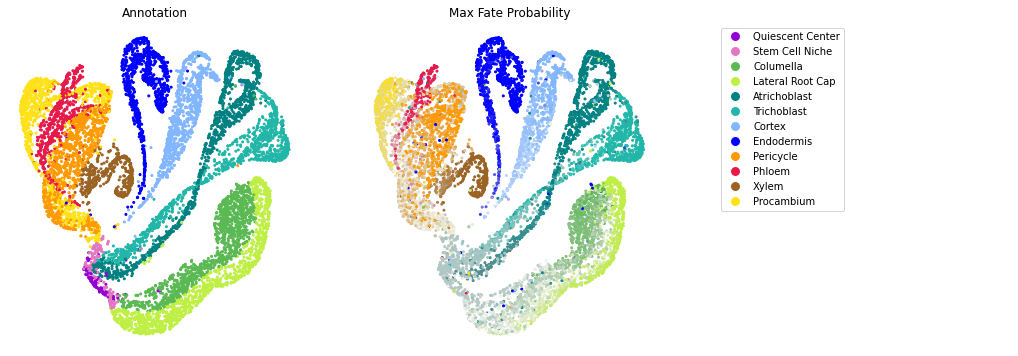

In [23]:
# Plot the umap by max lineage probability, faded by magnitude of fate probability
fig = plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.title('Annotation')
plt.axis('off')
plt.scatter(adata.obs.x, adata.obs.y, s = 4, c = adata.obs['lineage_color'])

plt.subplot(1,3,2)
plt.title('Max Fate Probability')
plt.axis('off')
plt.scatter(adata.obs.x, adata.obs.y, c=adata.obs['max_fate_color'], s=4)

plt.subplot(1,3,3)
plt.axis('off')
plt.legend(handles=lineage_handles, loc='upper left')

plt.show()

### Visualize Lineages with the CellRank Interface

> Indented block



statOT provides a wrapper to integrate will CellRank to produce plots using their plotting library. To generate plots with CellRank, you will need to install the cellrank package.

In [24]:
import cellrank
from statot import cr

To be compatible with CellRank, move the source and sink assignments. Additionally, CellRank can have issues with additional columns in obs, so we will create a copy of the data with a minimum number of columns in observations:

In [25]:
adata.uns['source'] = np.array(adata.obs['source'])
adata.uns['sink'] = np.array(adata.obs['sink'])

In [26]:
copy = adata.copy()
copy.obs = copy.obs[['growth', 'celltype.anno']]

In [27]:
scanpy.pp.neighbors(copy, 10)

We recalculate the coupling to generate a transition matrix.

In [28]:
ot_kernel = cr.OTKernel(copy, "source", "sink", g = growth, compute_cond_num = False)
ot_kernel.compute_transition_matrix(eps = 0.025, dt = 0.25, cost_norm_method = "mean", thresh = 0, verbose = False)

Using the CellRank interface we can plot the sinks and absorbtion probabilities:

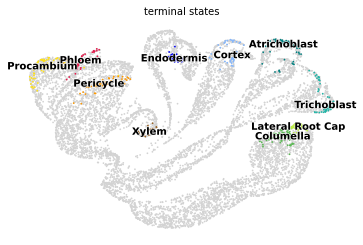

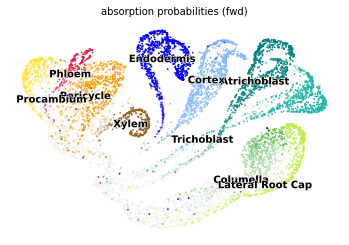

In [29]:
copy.uns["T_fwd"] = ot_kernel.transition_matrix
statot.cr.set_terminal_states(copy, sink_idx = copy.uns["sink"], labels = copy.obs["celltype.anno"], 
                              terminal_colors = ["#008080", "#5ab953", "#82b6ff", "#0000FF", "#bfef45", "#ff9900", "#e6194b", "#ffe119", "#21B6A8", "#9a6324"])
cellrank.pl.terminal_states(copy, discrete = True)
cellrank.tl.lineages(copy)
cellrank.pl.lineages(copy, same_plot = True)

### Using the KeOps/GPU implementation

Note that given the current state of the implementation, the details are left to the user and so we will need to work at more of a low-level.
Although in this example we are applying the method still to a 10k subset of cells from the full atlas, the KeOps/GPU implementation can be scaled to the full dataset of 110,000 cells with a runtime just over an hour.

In [80]:
# import statot.keops submodule
import statot.keops
statot.keops.set_dtype("float32") # single precision for GPU
from statot.keops import dtype

In [81]:
# generate source and target measures
mu, nu = statot.statot(adata.obsm['X_pca'], method = "marginals", g = growth, dt = 0.25)

In [ ]:
X = adata.obsm["X_pca"].astype(dtype)
# compute cost matrix as a LazyTensor and normalise to mean
C, norm = statot.keops.form_cost(X, X, norm_factor = "mean", keops = True) 
eps = 0.025
# compute Gibbs kernel
K = (-C/eps).exp()
# Sinkhorn iterations for dual potentials (u, v) 
u, v = statot.keops.sinkhorn(np.array(mu, dtype = dtype), 
                             np.array(nu, dtype = dtype), 
                             K, verbose = False, max_iter = 5000, err_check = 50, 
                             tol = 1e-9*mu.sum())

At this point, the OT coupling can be computed as `diag(u) K diag(v)`. However,
if we just want to compute fate probabilities, we do not proceed via computing `gamma`. Instead, we use the function `get_QR_submat` to compute the matrix `Q` (submatrix of transition probabilities between transient states) and `R` (submatrix of transitions from transient states to sink states).

In [83]:
Q, R = statot.keops.get_QR_submat(u, K, v, X, np.array(adata.obs.sink), eps, norm)

Finally, we need to aggregate the columns of `R` so that each column corresponds to a lineage (instead of a sink cell). This is necessary because the solver that we will use doesn't handle multiple LHS (i.e. doesn't use LU decomposition)

In [84]:
R_agg = np.array([R[:, adata.obs.loc[adata.obs.sink, "celltype.anno"] == l].sum(1) for l in np.unique(adata.obs.loc[:, "celltype.anno"])], dtype = dtype).T

Finally, we compute the fate probabilities matrix `B` with the matrix `Q` (which is much larger than `R`) being a LazyTensor.

In [85]:
B = statot.keops.compute_fate_probs(Q, R_agg)

Solving fate probabilities for lineage 0
Solving fate probabilities for lineage 1
Solving fate probabilities for lineage 2
Solving fate probabilities for lineage 3
Solving fate probabilities for lineage 4
Solving fate probabilities for lineage 5
Solving fate probabilities for lineage 6
Solving fate probabilities for lineage 7
Solving fate probabilities for lineage 8
Solving fate probabilities for lineage 9
Solving fate probabilities for lineage 10
Solving fate probabilities for lineage 11


In [86]:
B_full = np.zeros((adata.shape[0], len(np.unique(adata.obs.loc[:, "celltype.anno"]))))
B_full[~adata.obs.sink, :] = B
L = np.stack([np.unique(adata.obs.loc[:, "celltype.anno"]), ]*adata.shape[0])
A = np.array([adata.obs["celltype.anno"] == L[:, i] for i in range(L.shape[1])], dtype = np.int).T
B_full[adata.obs.sink, :] = A[adata.obs.sink, :]

In [87]:
# check agreement in fate probabilities between GPU and standard CPU methods 
[(B_full[:, i] - B_type[:, i]).max() for i in range(B_type.shape[1])]

[0.0005446937708591948,
 0.0002058385756785741,
 0.000347825712364247,
 0.00044261334485018455,
 0.0005051027901297189,
 0.00033844949200556584,
 6.66905636060866e-05,
 6.181053143120008e-05,
 0.0,
 0.0]

### References

[1] Shahan R, Hsu CW, Nolan TM, Cole BJ, Taylor IW, Vlot AHC, et al. A single cell Arabidopsis root atlas reveals developmental trajectories in wild type and cell identity mutants. bioRxiv. 2020. https://doi.org/10.1101/2020.06.29.178863.

[2] Rahni R, Birnbaum KD. Week-long imaging of cell divisions in the Arabidopsis
root meristem. Plant Methods. 2019;15(30). https://doi.org/10.1186/s13007-019-0417-9. 